In [1]:
from __future__ import annotations
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from edpyt.espace import build_espace, screen_espace
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [2]:
def load_full_bath_history(iter_filename):
    history = {}

    with h5py.File(iter_filename, "r") as f:
        bath_grp = f["all_bath_parameters"]
        for iter_name in sorted(bath_grp.keys(), key=lambda x: int(x.split("_")[1])):
            iter_data = bath_grp[iter_name]
            vk_list = []
            ek_list = []
            i = 0
            while f"vk_{i}" in iter_data:
                vk = iter_data[f"vk_{i}"][()]
                ek = iter_data[f"ek_{i}"][()]
                vk_list.append(vk)
                ek_list.append(ek)
                i += 1
            history[iter_name] = (vk_list, ek_list)

    return history


def plot_bath_parameter_evolution(history, impurity_index=0, param="vk"):
    """
    Plot the evolution of bath parameter ('vk' or 'ek') for a given impurity across iterations.

    Parameters:
        history (dict): Output from `load_full_bath_history()`
        impurity_index (int): Index of the impurity to plot
        param (str): 'vk' or 'ek'
    """
    assert param in ("vk", "ek"), "param must be 'vk' or 'ek'"

    iterations = sorted(history.keys(), key=lambda x: int(x.split("_")[1]))

    vk_evolution = []

    for iter_name in iterations:
        vk_list, ek_list = history[iter_name]
        data = vk_list if param == "vk" else ek_list

        if impurity_index >= len(data):
            raise IndexError(f"Impurity index {impurity_index} out of range in {iter_name}")

        vk_evolution.append(data[impurity_index])

    # Pad to equal length if needed
    max_len = max(len(vk) for vk in vk_evolution)
    vk_evolution_padded = np.array([
        np.pad(vk, (0, max_len - len(vk)), constant_values=np.nan)
        for vk in vk_evolution
    ])

    plt.figure(figsize=(10, 5))
    for i in range(vk_evolution_padded.shape[1]):
        plt.plot(vk_evolution_padded[:, i], label=f"{i}")

    plt.xlabel("DMFT Iteration")
    plt.ylabel(param)
    plt.title(f"Evolution of {param} for impurity {impurity_index}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def load_full_iteration_history(iter_filename):
    """
    Load all iteration data (delta, sigma, gfloc) from the HDF5 file.

    Returns:
        history (dict): Keys are iteration names like 'iteration_0', values are dicts with keys 'delta', 'sigma', 'gfloc'.
    """
    history = {}

    with h5py.File(iter_filename, "r") as f:
        iter_grp = f["last_n_iterations"]
        for iter_name in sorted(iter_grp.keys(), key=lambda x: int(x.split("_")[1])):
            data_grp = iter_grp[iter_name]
            delta = data_grp["delta"][()]
            sigma = data_grp["sigma"][()]
            gfloc = data_grp["gfloc"][()]
            history[iter_name] = {
                "delta": delta,
                "sigma": sigma,
                "gfloc": gfloc,
            }

    return history

def plot_quantity_vs_energy(history, iteration_num, quantity="delta", impurity_index=0, energy_axis=None, part="real"):
    """
    Plot delta/sigma/gfloc vs energy or complex frequency for a given iteration and impurity.

    Parameters:
        history (dict): Output from `load_full_iteration_history()`
        iteration_num (int): Iteration to plot (e.g. 3 means 'iteration_3')
        quantity (str): One of 'delta', 'sigma', or 'gfloc'
        impurity_index (int): Index of the impurity to plot
        energy_axis (array-like): Optional array of energies (real or complex) corresponding to data shape
        part (str): 'real', 'imag', or 'abs' — which part of the quantity to plot
    """
    assert quantity in ("delta", "sigma", "gfloc"), "Invalid quantity"
    assert part in ("real", "imag", "abs"), "part must be 'real', 'imag', or 'abs'"

    iter_key = f"iteration_{iteration_num}"
    if iter_key not in history:
        raise ValueError(f"{iter_key} not found in history")

    data = history[iter_key][quantity]
    if impurity_index >= len(data):
        raise IndexError(f"Impurity index {impurity_index} out of range in {iter_key}")

    y = data[impurity_index]

    if part == "real":
        y_plot = y.real
    elif part == "imag":
        y_plot = y.imag
    else:
        y_plot = np.abs(y)

    x = energy_axis if energy_axis is not None else np.arange(len(y_plot))

    plt.figure(figsize=(8, 5))
    plt.plot(x, y_plot)
    plt.xlabel("Energy" if energy_axis is not None else "Index")
    plt.ylabel(f"{part}({quantity})")
    plt.title(f"{quantity} for impurity {impurity_index} at iteration {iteration_num}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def list_available_iterations(iter_filename):
    """
    Print available iteration numbers in an iter.h5py file.
    """
    with h5py.File(iter_filename, "r") as f:
        if "last_n_iterations" not in f:
            raise KeyError("'last_n_iterations' group not found in the file")

        iter_names = list(f["last_n_iterations"].keys())
        iter_nums = sorted([int(name.split("_")[1]) for name in iter_names])
        return iter_nums

def get_last_bath_parameters(history):
    """
    Get the last bath parameters (vk, ek) for each impurity.

    Parameters:
        history (dict): Output from `load_full_bath_history()`

    Returns:
        last_vk_list (list of arrays): vk list for each impurity
        last_ek_list (list of arrays): ek list for each impurity
    """
    last_iter = sorted(history.keys(), key=lambda x: int(x.split("_")[1]))[-1]
    vk_list, ek_list = history[last_iter]
    return vk_list, ek_list

def compute_delta_from_bath(vk_list, ek_list, z_mats):
    """
    Compute delta(z) from bath parameters for all impurities.

    Parameters:
        vk_list (list of arrays): Each element is array of vk for an impurity
        ek_list (list of arrays): Each element is array of ek for an impurity
        z_mats (array): Matsubara energies

    Returns:
        delta_reconstructed (array): Sum over impurities of delta(z)
    """
    delta_total = np.zeros_like(z_mats, dtype=np.complex128)

    for vk, ek in zip(vk_list, ek_list):
        delta_imp = np.zeros_like(z_mats, dtype=np.complex128)
        for v, e in zip(vk, ek):
            delta_imp += v**2 / (z_mats - e)
        delta_total += delta_imp

    return delta_total


In [3]:
nsites_list = [4, 5, 6, 7]
relative_tols = [1e-4]
eta = 1e-3
data_folder = "./output/lowdin"
adjust_mus = [True]
U_list = [1e-3, 1e-2]
beta = 1000
temperature_data_folder = f"{data_folder}/beta_{beta}"
z_mats = np.load(f"{temperature_data_folder}/matsubara_energies.npy")

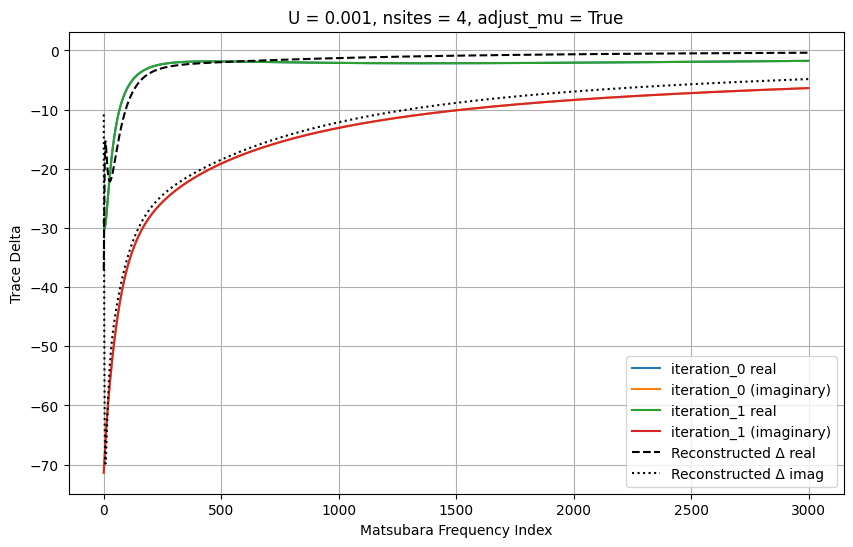

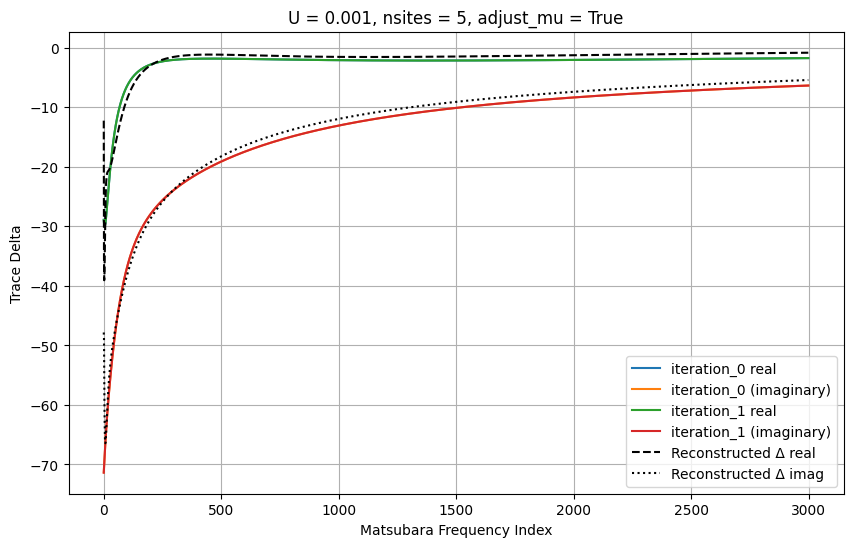

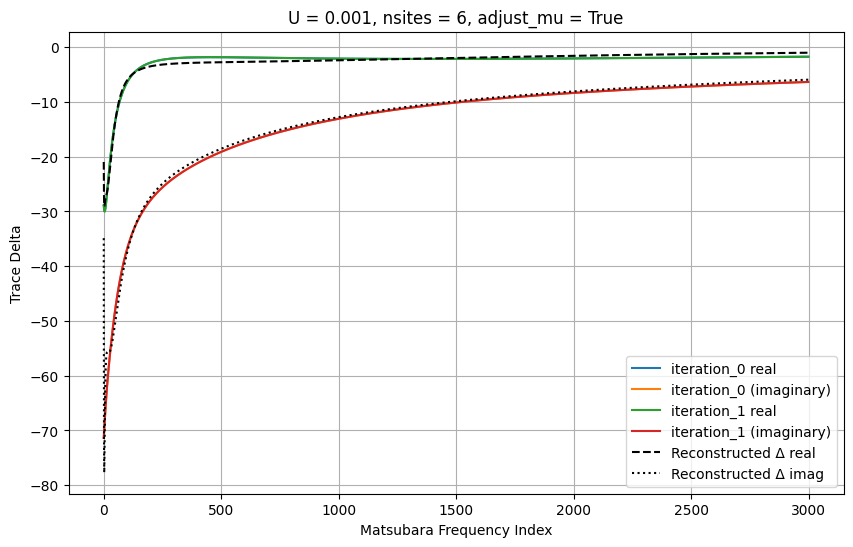

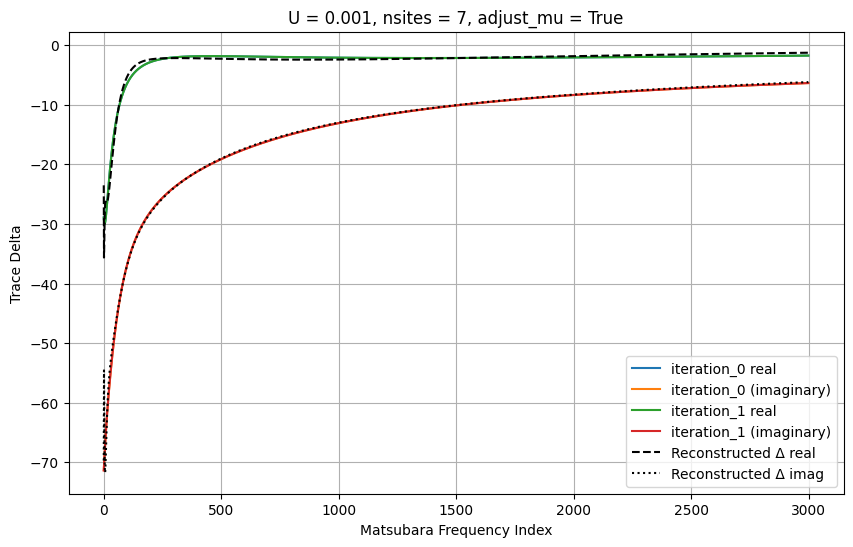

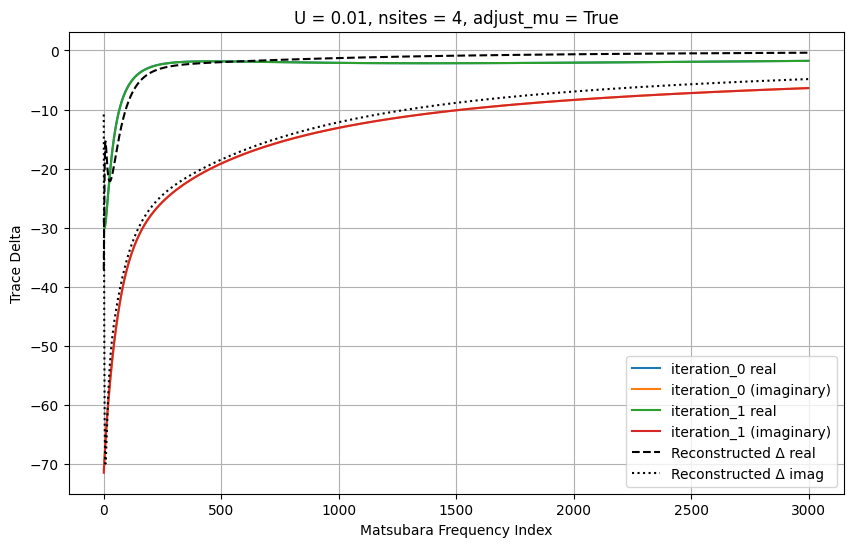

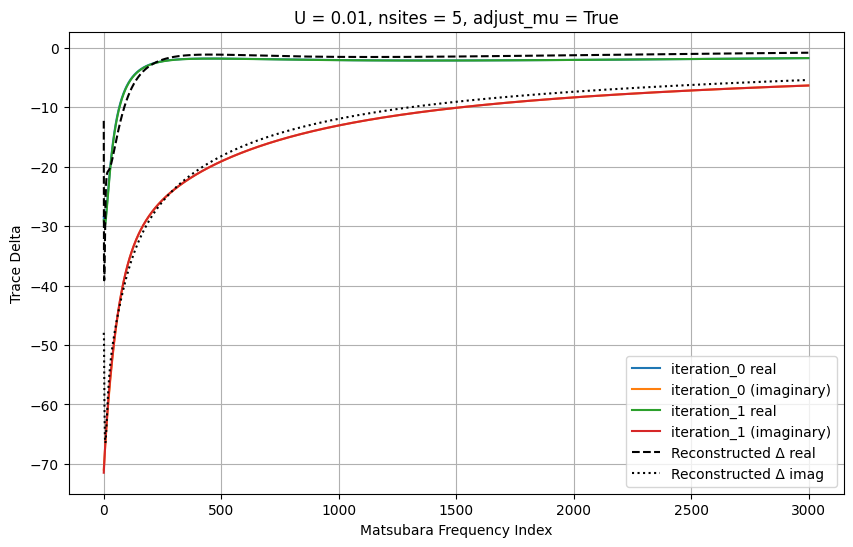

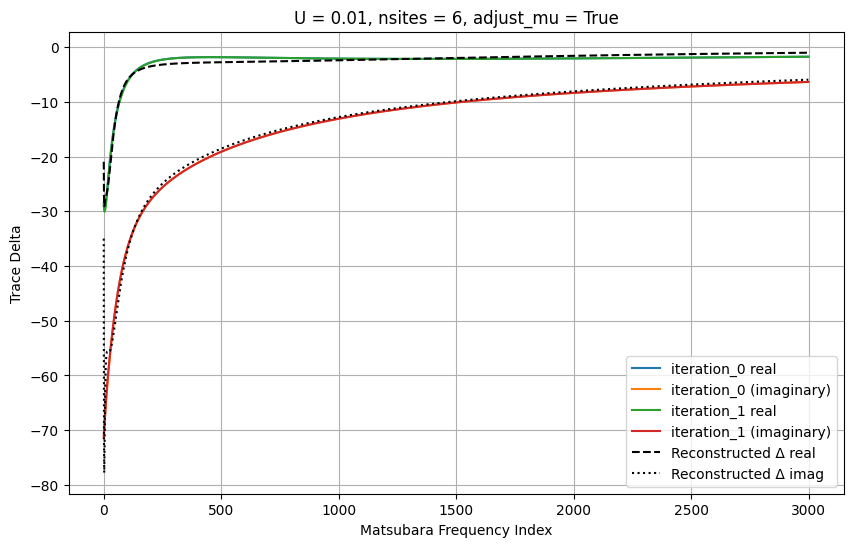

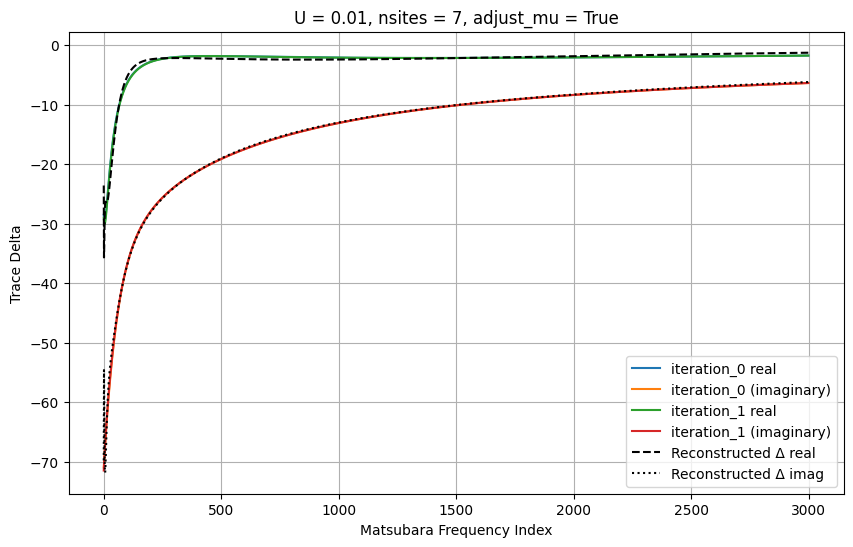

In [5]:

for relative_tol in relative_tols:
    for U in U_list:
        for nsites in nsites_list:
            for adjust_mu in adjust_mus:
                dmft_output_folder = f"{temperature_data_folder}/dmft/eta_{eta}/rel_tol_{relative_tol}/U_{U}/no_spin/nsites_{nsites}/adjust_mu_{adjust_mu}"

                bath_iter_filename = f"{dmft_output_folder}/bath_iter.h5py"
                delta_iter_filename = f"{dmft_output_folder}/iter.h5py"
                bath_history = load_full_bath_history(bath_iter_filename)
                vk_list, ek_list = get_last_bath_parameters(bath_history)
                delta_reconstructed = compute_delta_from_bath(vk_list, ek_list, z_mats)

                with h5py.File(delta_iter_filename, "r") as f:
                    iter_grp = f["last_n_iterations"]

                    iterations = sorted(iter_grp.keys(), key=lambda x: int(x.split('_')[-1]))

                    plt.figure(figsize=(10, 6))

                    for it in iterations:
                        delta = np.array(iter_grp[it]["delta"])
                        trace_delta = np.sum(delta,axis=0)
                        plt.plot(trace_delta.real, label=f"{it} real")
                        plt.plot(trace_delta.imag, label=f"{it} (imaginary)")

                    plt.plot(delta_reconstructed.real, 'k--', label="Reconstructed Δ real")
                    plt.plot(delta_reconstructed.imag, 'k:', label="Reconstructed Δ imag")
                    plt.title(f"U = {U}, nsites = {nsites}, adjust_mu = {adjust_mu}")
                    plt.xlabel("Matsubara Frequency Index")
                    plt.ylabel("Trace Delta")
                    plt.legend()
                    plt.grid(True)
                    plt.show()
